## Purpose of the Notebook

In this notebook, I'll formalize the observation from [recrystillization_inference.ipynb](recrystillization_inference.ipynb) and further developed in [latent_variable_selection.ipynb](latent_variable_selection.ipynb) that there appears to be a linear relationship between model parameters across data sets into the structure a statistial model. This observation implies that there is some _latent_ variable (the mean incubation/starting time and the mean inverse recrystillization rate) that the model specific paramters (_e.g._ $a_1,B_1,a_2,B_2,n$ for the JMAK model) are linearly related to via some _latent model_ which has _latent paramters_. This is formalized using Bayesian Hierarchical Modeling.

### Bayesian Hierarchical Modeling
Let $j = 1,...,m$ number the different data sets and $i = 1,...,N_j$ number the data in each data set. the model parameters $\theta_j = (a_{1,j},B_{1,j},n_j,a_{2,j},B_{2,j})$ (or $\nu_j$ for the GL model) are unique to each data set.Let $\mathcal{D} = \lbrace (\mathbf{X,t,T})_j \rbrace_{j = 1}^m $ be the data and $\Theta = \lbrace \theta_j \rbrace_{j = 1}^m$. 
We assume there are two latent variabls for each data set, $\overline{k}_j, \overline{t}_j$  and that the _latent parameters_ , $\mathbf{c}_k \in \mathbb{R}^{2}, k = 1,...,5$ for the parameter latent models, are independent of the particular data set, and relate the latent variables to the model parameters $\theta_j$ via an affine transform. The posterior we are after is 

$$p(\mathbf{c},\mathbf{\overline{k}},\mathbf{\overline{t}} | \mathcal{D}) \propto \mathcal{L}(\mathcal{D} | \mathbf{c},\mathbf{\overline{k}}, \mathbf{\overline{t}}) \pi(\mathbf{c},\mathbf{\overline{k}},\mathbf{\overline{t}})$$

The likelihood of the data is computed using the latent model as:

$$\begin{matrix*}[l]
\mathcal{L}(\mathcal{D} | \mathbf{c},\mathbf{\overline{k}},\mathbf{\overline{t}}) = \mathcal{L}(\mathcal{D} | \{\theta_j \}_{j = 1}^m ) = \prod_{j = 1}^{m} L_j((\mathbf{X,t,T})_j | \theta_j ) \\
L_j((\mathbf{X,t,T})_j | \theta_j ) = \prod_{i = 1}^{N_j} \varepsilon_{ij} \\ 
\varepsilon_{ij} = X_{ij} - \hat{X}_{ij} \sim \mathcal{N}(0,\sigma_{j}^2 + \xi_{i}^2) \\
\hat{X}_{ij} = 1 - \exp{\left(-b(T_{ij})^{n_j}(t_{ij} - t_{inc}(T_{ij}))^{n_j}\right)} \\
b(T_{ij}) = \exp{\left(a_{1,j} + \frac{B_{1,j}}{T_{ij}}\right)}\\
t_{inc}(T_{ij}) = \exp{\left(a_{2,j} + \frac{B_{2,j}}{T_{ij}} \right)} \\ 
a_{1,j} = c_{1,1} + c_{1,2} \ln{\overline{k}_j} \\ 
B_{1,j} =  c_{2,1} + c_{2,2} \ln{\overline{k}_j} \\ 
n_{j} = c_{3,1} + c_{3,2} \ln{\overline{k}_j}   \\
a_{2,j} = c_{4,1} + c_{4,2} \ln{\overline{t}_j} \\ 
B_{2,j} =  c_{5,1} + c_{5,2} \ln{\overline{t}_j}\\
\end{matrix*}$$

As commonly done, I assume that the priors for the latent variables and parameters are independent.

$$
\pi(\mathbf{c},\mathbf{\overline{k}},\mathbf{\overline{t}}) = \pi(\mathbf{c})\pi(\mathbf{\overline{k}}) \pi(\mathbf{\overline{t}})
$$

Where we specify some prior distribution for the latent parameters and variables based on the previous [inference results](recrystillization_inference.ipynb) estimated [here](latent_variable_selection.ipynb). $\xi_{i}^2$ is the fixed, known, variance from the experiments.


In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
import numpyro

from jax import random
import jax.numpy as jnp
from numpyro.infer import init_to_mean, init_to_value
import warnings
from typing import Callable, Dict,Tuple, List, Any

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))

from common_util import setup_axis_default, jmak_fit_model_setup,gl_fit_model_setup,kbar_jmak,kbar_gl,tbar,get_data_multiplier,\
                        _FILE_TO_LABEL as file_to_label

In [5]:
from typing import List, Dict, Tuple
from numpyro.distributions import Distribution
from statsmodels.regression.linear_model import OLS, OLSResults
from jax import vmap
from numpyro.distributions import MultivariateNormal, Uniform

def normal_prior_lm(name: str,
                    params: Tuple[jnp.ndarray| np.ndarray],
                    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]) -> Tuple[str,Distribution,Callable]:

    """
    make a linear latent model with a normal prior on the parameters, specified by 
    the mean and covariance.

    Args:
    ---------
    name: str
        the name of the latent model
    params: Tuple[jnp.ndarray| np.ndarray]
        the mean and covariance of the normal prior
    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]
        the transformation to apply to the latent variables before applying the linear model

    Returns:
    ---------
    Tuple[str,Distribution,Callable]
    The name, distribution, and latent model function, with a None placeholder for sampled parameters
    """
    def linear_latent_model(x: jnp.ndarray,p: jnp.ndarray):
        x_ = latent_transform(x)
        y = jnp.sum(x_ * p,axis = -1)
        return y

    return [name,MultivariateNormal(params[0],params[1]),linear_latent_model,None]

def uniform_prior_lm(name: str,
                    params: Tuple[jnp.ndarray| np.ndarray],
                    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]) -> Tuple[str,Distribution,Callable]:

    """
    Effectively the same as normal_prior_lm, but with a uniform prior on the parameters
    """
    def linear_latent_model(x: jnp.ndarray,p: jnp.ndarray):
        x_ = latent_transform(x)
        y = jnp.sum(x_ * p,axis = -1)
        return y

    a = params[0] - 3.0*jnp.sqrt(params[1])
    b = params[0] + 3.0*jnp.sqrt(params[1])
    return [name,Uniform(a,b),linear_latent_model,None]

def statsmodels_lm_to_bayesian(name: str,
                               ols: OLSResults,
                               latent_transform: Callable[[jnp.ndarray],jnp.ndarray],
                               prior = 'normal') -> Tuple[str,
                                                        Distribution,
                                                        Callable]:

    """
    utility to convert a statsmodels OLS model to a bayesian model with a normal or uniform prior
    """
    try:
        return {'normal':normal_prior_lm(name,(ols.params,5*ols.cov_params()),latent_transform),
        'uniform':uniform_prior_lm(name,(ols.params,5*np.diag(ols.cov_params())),latent_transform)}[prior]
    except KeyError:
        raise ValueError('Invalid prior type. Must be one of "normal" or "uniform"')

def alm(latent_model_tuple: Tuple[jnp.ndarray,Callable], 
                       x: jnp.ndarray) -> jnp.ndarray:
    
    """
    apply the latent model
    """
    _,_,latent_model,latent_params = latent_model_tuple
    return latent_model(x,latent_params)

def slm(latent_model_tuple: List[Any], 
        latent_variable: jnp.ndarray,
        params: jnp.ndarray) -> jnp.ndarray:
    """
    sample latent model output from provided samples
    """
    _,_,latent_model,_ = latent_model_tuple
    latent_model_tuple[-1] = params
    return latent_model(latent_variable,params)

#affine transformations for the latent variables
def log_kbar_tform(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([jnp.ones([x.shape[0],1]),x[...,0:1]],axis = 1)

def log_tbar_tform(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([jnp.ones([x.shape[0],1]),x[...,1:2]],axis = 1)

def jmak_single_model_prediction(t: jnp.ndarray,
                            T: jnp.ndarray,
                            std: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            latent_var : jnp.ndarray,
                            sigma: float) -> Tuple[jnp.ndarray,jnp.ndarray]:
    
    #apply the latent models to the sampled latent variables and latent model parameters
    a1 = alm(latent_models['a1'],latent_var)
    B1 = alm(latent_models['B1'],latent_var)
    n = alm(latent_models['n'],latent_var)
    a2 = alm(latent_models['a2'],latent_var)
    B2 = alm(latent_models['B2'],latent_var)
    #compute the arrhenius parameters from the model parameters
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    
    #compute the model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)

    return Xhat,std + sigma

def gl_single_model_prediction(t: jnp.ndarray,
                            T: jnp.ndarray,
                            std: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            latent_var : jnp.ndarray,
                            sigma: float) -> Tuple[jnp.ndarray,jnp.ndarray]:
    
    #apply the latent models to the sampled latent variables and latent model parameters
    a1 = alm(latent_models['a1'],latent_var)
    B1 = alm(latent_models['B1'],latent_var)
    nu = alm(latent_models['nu'],latent_var)
    a2 = alm(latent_models['a2'],latent_var)
    B2 = alm(latent_models['B2'],latent_var)

    #compute the arrhenius parameters from the model parameters
    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)
    
    #compute the model prediction
    Xhat = (1.+ jnp.exp(-B*(t - M)))**(-1./nu)

    return Xhat,std + sigma


### Multivariate Normal Approximation of the Prior 

For sampling from the posterior, it is convinient to assume the assumptions of linear regression are met and we have 

$$
\begin{matrix*}[l]
y = \beta_0 + \beta_1 \ln{\overline{k}} + \varepsilon \qquad y \in \{a_1,B_1,n\}  \\ 
y = \beta_0 + \beta_1 \ln{\overline{t}} + \varepsilon \qquad y \in \{a_2,B_2\}  \\
\varepsilon \sim \mathcal{N}(0,\sigma^2)
\end{matrix*}
$$

from which it follows that $\beta \sim \mathcal{N}(\hat{\beta},\sigma^2 (\mathbf{X}^T\mathbf{X})^{-1})$ where $\mathbf{X}$ has the first column of all 1's and the second $\ln{\overline{k}},\ln{\overline{t}}$ for the regression under consideration. We can examine these assumptions via a qq-plot of the residuals $\hat{\varepsilon}$ of the fit below. For $a_1,B_1$ it appears the assumptions are nicely met. Even with $n$ the residuals are decidely not normal; the deviations from normality for $a_2,B_2$ are even greater. 

However, the distributions of the coefficients in the linear models are provided to the sampling procedure as merely a prior, and thus their accuracy is not of crucial import. The information provided is enough to restrict the sample space, and the likelihood provides the rest of the posterior shape. It might be interesting to experiment with different priors that more adequently fit the data in the future.

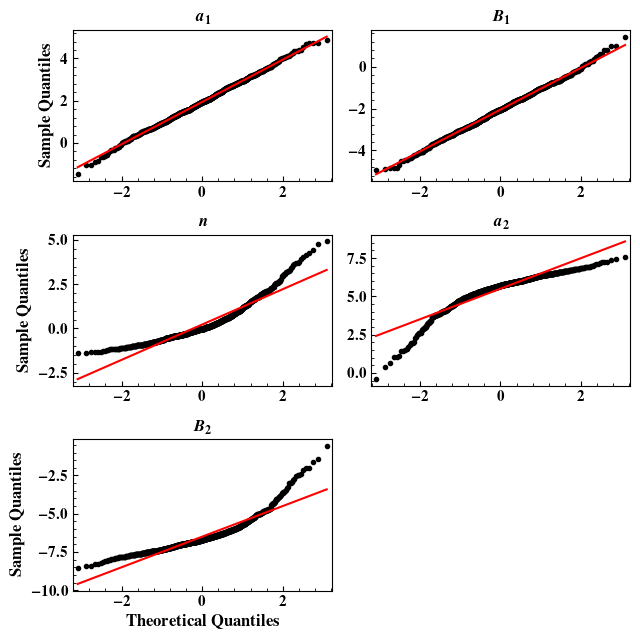

In [ ]:
from statsmodels.api import add_constant,qqline,qqplot
from scipy.stats import probplot

T_1 = 800.0 + 273.15
T_2 = 1300.0 + 273.15
model_name = 'Generalized Logistic_{}'
ep_param = 'n' if 'JMAK' in model_name else 'nu'
single_model_prediction = jmak_single_model_prediction if 'JMAK' in model_name else gl_single_model_prediction
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl
files = [file for file in file_to_label if 'shah' not in file.lower()][:1]

total_samples = []
for i,file in enumerate(files):
    dname = file_to_label[file]
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(dname)}_trunc_normal_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f)).iloc[::20]

    for row in samples.index:
        with warnings.catch_warnings(action = 'ignore'): 
            samples.loc[row,'k_bar']=  np.log(kbar(samples.loc[row,'a1'],samples.loc[row,'B1'],samples.loc[row,ep_param],T_1,T_2))
            samples.loc[row,'t_bar'] = np.log(tbar(samples.loc[row,'a2'],samples.loc[row,'B2'],T_1,T_2))


    total_samples.append(samples.copy())

with open(INFERENCE_PATH.joinpath(f'{model_name.format('prior_linear_models_trunc_normal')}.pkl'),'rb') as f:  
    linear_models = pickle.load(f)

total_samples = pd.concat(total_samples,axis = 0)

fig,axes = plt.subplots(nrows = 3,ncols = 2,figsize = (6.5,6.5))
titles = {'a1':r'$a_1$','B1':r'$B_1$','a2': r'$a_2$','B2':r'$B_2$','n':r'$n$',
           'nu': r'$\nu$','k_bar': r'$\ln{\overline{k}}$','t_bar': r'$\ln{\overline{t}}$'}

tfroms = [log_kbar_tform]*3 + [log_tbar_tform]*2
params = ['a1','B1',ep_param] + ['a2','B2']


dep_variable  = ['k_bar']*3 + ['t_bar']*2
for param,tform,dv,ax in zip(params,tfroms,dep_variable,axes.flat):
    setup_axis_default(ax)
    pred = linear_models[param].predict(add_constant(total_samples[dv].values))
    resid = total_samples[param].values - pred

    scaled_resid = resid/np.std(resid,ddof = 2)
    ax.set_title(titles[param]) 
    qqplot(scaled_resid,ax = ax,
           markerfacecolor = 'k',
           markeredgecolor = 'k',marker = 'o',lw = 0.1,
           markersize = 3.0,line  = 's')
    ax.set_xlabel('')
    ax.set_ylabel('')

for ax in axes[:,0]:
    ax.set_ylabel(r'\textbf{Sample Quantiles}',fontsize = 12)

for ax in axes[-1,:]:
    ax.set_xlabel(r'\textbf{Theoretical Quantiles}',fontsize = 12)

axes[-1,-1].axis('off') 
fig.tight_layout()


### Hierarchical Model Inference
Sample the posterior as described in the first cell. The syntax here is not very nice, mostly because jax doesn't really support object orientated programming, sacrificing composibility and readibility for (incredible) performance.

In [16]:
from numpyro.distributions import Normal, Exponential, TruncatedNormal
rng_key = random.PRNGKey(92)
rng_key, rng_key_ = random.split(rng_key)

#Model Specific Setup
model_name = 'Generalized Logistic_{}'
single_model_prediction = jmak_single_model_prediction if 'JMAK' in model_name else gl_single_model_prediction
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl
ep_param = 'n' if 'JMAK' in model_name else 'nu' 
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup

def jmak_numpyro_hierarchical_model(t: List[jnp.ndarray],
                                    T: List[jnp.ndarray],
                                    X: List[jnp.ndarray],
                                    std: List[jnp.ndarray],
                                    latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                                    latent_means: jnp.ndarray,
                                    latent_std: jnp.ndarray) -> None:
                      
    """
    numpyro/jax numpy compatible model for the JMAK model
    """
    X_ = jnp.concatenate(X)

    # priors for "latent" variables
    latent_dist = Normal(latent_means,latent_std)
    latent_var = numpyro.sample('latent_variables',latent_dist)

    #set-up the latent models
    for p,(name,dist,_,_)  in latent_models.items():
        latent_models[p][-1] = numpyro.sample(name,dist)

    #priors for the model error
    sigma = numpyro.sample('sigma',Exponential(10.0).expand([latent_means.shape[0]]))

    Xhat_list =[]
    std_list = []
    #compute the model predictions and stds for each data set
    for i,(t_,T_,std_) in enumerate(zip(t,T,std)):
        Xhat,std_dev = single_model_prediction(t_,T_,std_,latent_models,latent_var[i:i+1,...],sigma[i])
        Xhat_list.append(Xhat)
        std_list.append(std_dev)
    
    Xhat = jnp.concatenate(Xhat_list)
    tt_std = jnp.concatenate(std_list)

    #sample the joint likelihood
    with numpyro.plate('data',X_.shape[0]):
        numpyro.sample('obs',TruncatedNormal(loc = Xhat,scale = tt_std,low = 0.0,high = 1.),obs = X_)

#read in data and prior estimation for latent variables and parameters
t,T,X,std = [],[],[],[]
T_1 = 800.0 + 273.15
T_2 = 1300.0 + 273.15
latent_means,latent_stds = [],[]

files = [file for file in file_to_label if 'shah' not in file.lower()]
for i,file in enumerate(files):
    dname = file_to_label[file]
    t_,T_,X_,df,_,_ = model_setup(file, mult = get_data_multiplier(file))
    t.append(jnp.array(t_)),T.append(jnp.array(T_)),X.append(jnp.array(X_))
    
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(dname)}_trunc_normal_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f)).iloc[::20]

    for row in samples.index:
        with warnings.catch_warnings(action = 'ignore'): 
            samples.loc[row,'k_bar']=  np.log(kbar(samples.loc[row,'a1'],samples.loc[row,'B1'],samples.loc[row,ep_param],T_1,T_2))
            samples.loc[row,'t_bar'] = np.log(tbar(samples.loc[row,'a2'],samples.loc[row,'B2'],T_1,T_2))
    
    latent_means.append(jnp.array(samples[['k_bar','t_bar']].to_numpy().mean(axis = 0)))
    latent_stds.append(jnp.array(samples[['k_bar','t_bar']].to_numpy().std(axis = 0)))
    std.append(jnp.array(df['std'].to_numpy()))

latent_means = jnp.array(latent_means)
latent_stds = jnp.array(latent_stds)

#read in prior linear models fitted in seperate notebook to help the inference
with open(INFERENCE_PATH.joinpath(f'{model_name.format('prior_linear_models_trunc_normal')}.pkl'),'rb') as f:  
    linear_models = pickle.load(f)

latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform,prior = 'normal') for param in ['a1','B1',ep_param]}
latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform,prior = 'normal') for param in ['a2','B2']})

#setup the MCMC method
nuts_kernel = numpyro.infer.NUTS(jmak_numpyro_hierarchical_model,init_strategy= init_to_mean)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=20000,
    num_warmup=10000,
    num_chains= 1
)

#run the MCMC
mcmc.run(rng_key_,t,T,X,std,latent_models,latent_means,latent_stds)
mcmc.print_summary()

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'wb') as f:
    pickle.dump(mcmc.get_samples(),f)

No standard deviation column found, using 0.001 for all values


sample: 100%|██████████| 30000/30000 [27:06<00:00, 18.45it/s, 511 steps of size 1.20e-02. acc. prob=0.91] 



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                B1[0]  16573.66    327.10  16573.52  16012.79  17083.00  11919.25      1.00
                B1[1]  -3012.91     14.72  -3012.95  -3036.87  -2988.70  11931.25      1.00
                B2[0]  31188.98      2.66  31186.32  31186.32  31186.32      0.50      1.00
                B2[1]    962.03     22.09    962.14    926.29    998.99  16768.74      1.00
                a1[0]    -16.30      0.23    -16.30    -16.68    -15.92  11432.76      1.00
                a1[1]      1.76      0.01      1.76      1.74      1.78  11364.90      1.00
                a2[0]    -29.24      0.64    -29.23    -30.27    -28.17  10885.43      1.00
                a2[1]      0.28      0.02      0.28      0.25      0.30  18344.57      1.00
latent_variables[0,0]     15.37      0.28     15.38     14.91     15.83  15345.63      1.00
latent_variables[0,1]     19.63      0.75     19.63     18.39     20.86   8992.

### Hierarchical Model Maximum Likelihood Estimation

Always good to get the MLE, use the same method as in [recrystillization_inference.ipynb](recrystillization_inference.ipynb) .

In [17]:
import jax
from common_util import resampled_adam

#Model Specific Setup
model_name = 'Generalized Logistic_{}'
single_model_prediction = jmak_single_model_prediction if 'JMAK' in model_name else gl_single_model_prediction
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl
ep_param = 'n' if 'JMAK' in model_name else 'nu' 
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup

#read in prior linear models fitted in seperate notebook
with open(INFERENCE_PATH.joinpath(f'{model_name.format('prior_linear_models_trunc_normal')}.pkl'),'rb') as f:  
    linear_models = pickle.load(f)

#convert the linear models to bayesian priors
latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform) for param in ['a1','B1',ep_param]}
latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform) for param in ['a2','B2']})

#the optax library can't handle non-jax arrays, so we need to convert the samples to jax arrays and then re-convert 
#in the optmization function . This is surprisingly faster than expected, I suppose the vmap function built into
# the optimization function I'm using somehow speeds up the process
def param_map(params: jnp.ndarray) -> Tuple[jnp.ndarray]:

    a1 = params[:2]
    B1 = params[2:4]
    n = params[4:6]
    a2 = params[6:8]
    B2 = params[8:10]
    latent_var = params[10:-5].reshape((5,2))
    sigma = params[-5:]
    return a1,B1,n,a2,B2,latent_var,sigma
                    
def model_likelihood(params: jnp.ndarray,
                    t: List[jnp.ndarray],
                    T: List[jnp.ndarray],
                    X: List[jnp.ndarray],
                    std: List[jnp.ndarray]) -> float:
    
    a1,B1,n,a2,B2,latent_var,log_error = param_map(params)
    latent_models['a1'][-1] = a1
    latent_models['B1'][-1] = B1
    latent_models[ep_param][-1] = n
    latent_models['a2'][-1] = a2
    latent_models['B2'][-1] = B2
    X_ = jnp.concatenate(X)
    #compute the model predictions and stds for each data set
    Xhat_list =[]
    std_list = []
    #compute the model predictions and stds for each data set
    for i,(t_,T_,std_) in enumerate(zip(t,T,std)):
        Xhat,std_dev = single_model_prediction(t_,T_,std_,latent_models,latent_var[i:i+1,...],jnp.exp(log_error[i]))
        Xhat_list.append(Xhat)
        std_list.append(std_dev)
    
    Xhat = jnp.concatenate(Xhat_list)
    tt_std = jnp.concatenate(std_list)

    #sample the joint likelihood
    return TruncatedNormal(Xhat,tt_std,low = 0.0,high = 1.0).log_prob(X_).sum()

 #read in data from all the models
t,T,X,std = [],[],[],[]
files = [file for file in file_to_label if 'shah' not in file.lower()]
for i,file in enumerate(list(files)):
    dname = file_to_label[file]
    t_,T_,X_,df,_,_ = model_setup(file, mult = get_data_multiplier(file))
    t.append(jnp.array(t_)),T.append(jnp.array(T_)),X.append(jnp.array(X_))
    std.append(jnp.array(df['std'].to_numpy()))

#define optimization function
def opt_func(params: jnp.ndarray):
    return -model_likelihood(params,
                            t,T,X,std)

model_params = ['a1','B1',ep_param,'a2','B2','latent_variables','sigma']
with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)

posterior_samples = {key: jnp.array(posterior_samples[key]) for key in model_params}
posterior_samples['sigma'] = jnp.log(posterior_samples['sigma'])

array_samples = jnp.concat([posterior_samples[key].reshape((posterior_samples[key].shape[0],-1)) for key in model_params],axis = 1)
NUM_SAMPLES = 50

posterior_likelihood = jax.vmap(opt_func,
                                in_axes = (0))(array_samples)

best_sample_index = np.argsort(posterior_likelihood)[:NUM_SAMPLES]

init_samples = array_samples[best_sample_index]
opt_params,posterior_value = resampled_adam(init_samples,opt_func,lr = 2.5e-4,opt_iter = int(2e3))
a1,B1,n,a2,B2,latent_var,log_error = param_map(opt_params)

opt_params = {'a1': a1,
              'B1': B1,
              ep_param: n,
              'a2': a2,
              'B2': B2,
              'latent_variables': latent_var,
              'sigma': jnp.exp(log_error)}

inf_summary = {'ml': opt_params,
               'mean': {key: jnp.mean(posterior_samples[key],axis = 0) for key in model_params},
               'std': {key: jnp.std(posterior_samples[key],axis = 0) for key in model_params}}

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_params.pkl'),'wb') as f:
    pickle.dump(inf_summary,f)


No standard deviation column found, using 0.001 for all values


Optimizing: 100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


### Posterior Predictive Distributions

No standard deviation column found, using 0.001 for all values
No standard deviation column found, using 0.001 for all values


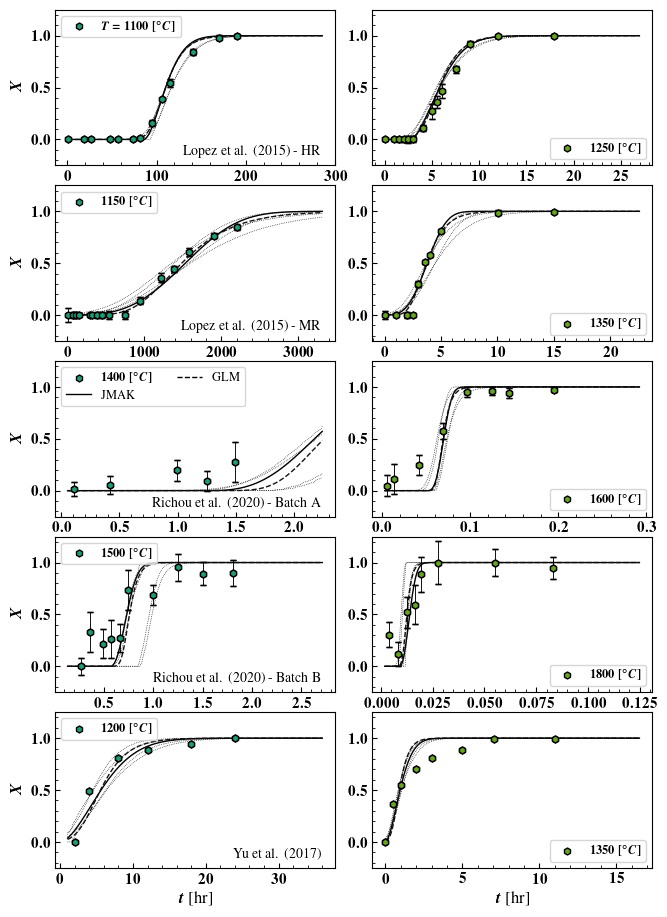

In [18]:
from common_util import get_data_label  
from matplotlib.lines import Line2D

def jmak_posterior_predictive(t: jnp.ndarray,
                              T: jnp.ndarray,
                              latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                              a1_coeff: jnp.ndarray,
                              B1_coeff: jnp.ndarray,
                              n_coeff: jnp.ndarray,
                              a2_coeff: jnp.ndarray,
                              B2_coeff: jnp.ndarray,
                              latent_variables : jnp.ndarray) -> jnp.ndarray:
    
    #sample the latent model variables and latent parameters
    a1 = slm(latent_models['a1'],latent_variables,a1_coeff)[np.newaxis,...]
    B1 = slm(latent_models['B1'],latent_variables,B1_coeff)[np.newaxis,...]
    n = slm(latent_models['n'],latent_variables,n_coeff)[np.newaxis,...]
    a2 = slm(latent_models['a2'],latent_variables,a2_coeff)[np.newaxis,...]
    B2 = slm(latent_models['B2'],latent_variables,B2_coeff)[np.newaxis,...]

    #compute the model prediction using the samples
    b = np.exp(a1 + B1/T[...,np.newaxis])
    t_inc = np.exp(a2 + B2/T[...,np.newaxis])
    t_eff = t[...,np.newaxis] - t_inc
    t_eff[t_eff < 0.] = 0.0   

    Xhat = 1.0 - np.exp(-b**n*t_eff**n)
    return Xhat

def gl_posterior_predictive(t: jnp.ndarray,
                            T: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            a1_coeff: jnp.ndarray,
                            B1_coeff: jnp.ndarray,
                            nu_coeff: jnp.ndarray,
                            a2_coeff: jnp.ndarray,
                            B2_coeff: jnp.ndarray,
                            latent_variables : jnp.ndarray) -> jnp.ndarray:
    
    a1 = slm(latent_models['a1'],latent_variables,a1_coeff)[np.newaxis,...]
    B1 = slm(latent_models['B1'],latent_variables,B1_coeff)[np.newaxis,...]
    nu = slm(latent_models['nu'],latent_variables,nu_coeff)[np.newaxis,...]
    a2 = slm(latent_models['a2'],latent_variables,a2_coeff)[np.newaxis,...]
    B2 = slm(latent_models['B2'],latent_variables,B2_coeff)[np.newaxis,...]

    B = np.exp(a1 + B1/T[...,np.newaxis])
    M = np.exp(a2 + B2/T[...,np.newaxis])

    Xhat = (1.+ np.exp(-B*(t[...,np.newaxis] - M)))**(-1./nu)
    return Xhat

def plot_posterior_prediction(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: Dict[str,np.ndarray], 
                              temperature: float,
                              exp_data: pd.DataFrame,
                              posterior_samples: Dict[str,np.ndarray],
                              latent_models: Dict[str,Tuple[np.ndarray,Callable]],
                              style: str = '-',
                              pred_color: str = 'k',
                              model_params = ['a1','B1','n','a2','B2','latent_variables']) -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    data = exp_data.loc[df['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    predictions = model_func(t,(temperature + 273.15)*np.ones_like(t),
                             latent_models,*(posterior_samples[key] for key in model_params))

    #Estimate using ML parameters
    ml_pred = model_func(t,(temperature + 273.15)*np.ones_like(t),
                        latent_models,*(ml_est[key][np.newaxis,:] for key in model_params))

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions.T,0.95)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    
def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[df['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 25,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

#plot the posterior predictive for the JMAK and GLM models for some sample isothermal temperatures
fig,axes = plt.subplots(nrows = 5,ncols = 2,figsize = (6.5,9))

file_to_index = {file: i for i,file in enumerate(list(file_to_label.keys()))}   
temperatures  = {'alfonso_data/highly_rolled.csv': [1100,1250],
                'alfonso_data/moderate_roll.csv': [1150,1350],
                'richou_data/batch_a_data.csv': [1400,1600],
                'richou_data/batch_b_data.csv': [1500,1800],
                 'yu_data/data.csv': [1200,1350]}

temperatures = {get_data_label(DATA_DIR.joinpath(file)): temps for file,temps in temperatures.items()}

for k,model_name,model_func,model_setup,ep_param,color,style in zip(range(2),['JMAK_{}','Generalized Logistic_{}'],
                                             [jmak_posterior_predictive,gl_posterior_predictive],
                                             [jmak_fit_model_setup,gl_fit_model_setup],
                                             ['n','nu'],
                                             ['k',(20/255,20/255,20/255)],
                                             ['-','--']):

    with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)
    
    with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_params.pkl'),'rb') as f:
        inf_summary = pickle.load(f)

    with open(INFERENCE_PATH.joinpath(f'{model_name.format('prior_linear_models_trunc_normal')}.pkl'),'rb') as f:  
        linear_models = pickle.load(f)

    latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform,prior = 'uniform') for param in ['a1','B1',ep_param]}
    latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform,prior = 'uniform') for param in ['a2','B2']})

    ml_params = inf_summary['ml']
    ml_latent_var = ml_params['latent_variables'].copy()
    posterior_samples_latent_var= posterior_samples['latent_variables'].copy()

    for i,file in enumerate(list(file_to_label.keys())[:-1]): #count rows/datasets
        ml_params['latent_variables'] = ml_latent_var[file_to_index[file]]
        posterior_samples['latent_variables'] = posterior_samples_latent_var[:,file_to_index[file],:]
        t,T,X,df,bounds,p0 = model_setup(file, mult = get_data_multiplier(file))    
        for j,plot_temperature,exp_color in zip(range(2),temperatures[get_data_label(file)],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
            plot_posterior_prediction(axes[i,j],model_func,ml_params,
                                      plot_temperature,df,posterior_samples,latent_models,style = style,pred_color = color,
                                    model_params = ['a1','B1',ep_param,'a2','B2','latent_variables'])
            plot_experimental_data(axes[i,j],df,plot_temperature,exp_color,first_label = (i == 0 and j == 0),
                                   make_label = k == 0)

for ax,data_label in zip(axes[:,0],file_to_label.values()):
    ax.set_ylabel(r'$X$',fontsize = 12)
    ax.text(0.95, 0.05, data_label , ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

for ax in axes[-1,:]:
    ax.set_xlabel(r'$t$ [hr]',fontsize = 12)

for i in range(5):
    for j in range(2):
        setup_axis_default(axes[i,j])
        axes[i,j].set_ylim([-0.25,1.25])
        #ax.set_xscale('log')   
        #final formatting

        if i == 2 and j == 0: 
            legend_patches  = [Line2D([],[],color = 'k',lw = 1.0,ls = '-',label = 'JMAK'),
                            Line2D([],[],color = 'k',lw = 1.0,ls = '--',label = 'GLM')]
            handles,axes_labels = axes[i,j].get_legend_handles_labels()
            axes[i,j].legend(handles + legend_patches,
                             axes_labels + ['JMAK','GLM'],
                             fontsize = 9,ncol = 2,loc = 'upper left')
        elif j == 1:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'lower right')
        else:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'upper left')
        

fig.tight_layout(pad = 0.1) 
fig.savefig(GIT_IMAGE_PATH.joinpath('posterior_predictive_comparison_hierarchical_truncated_normal.svg'))


## Posterior Distribution Visualization
### Latent Variables
It's useful to visualize the marginal distributions of the latent variables $\bar{k}$ and $\bar{t}$ for each of the data sets.

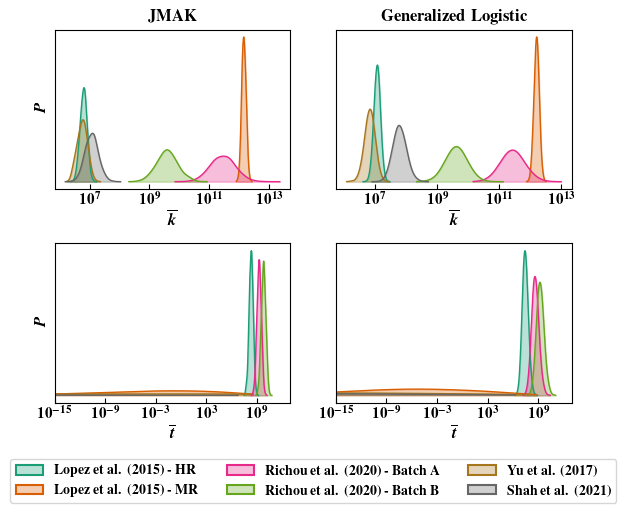

In [19]:
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

fig,axes = plt.subplot_mosaic("""
                              AB
                              CD
                              EE
                              """,
                              height_ratios= [1,1,0.3],
                              figsize = (6.5,5.25))

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))

legend_axes = axes['E']
axes = np.array([[axes['A'],axes['B']],[axes['C'],axes['D']]])

for j,model_name in enumerate(['JMAK_{}','Generalized Logistic_{}']):
    axes[0,j].set_title(r'\textbf{' + model_name[:-3] +'}')
    with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)['latent_variables']
 
    for k,latent_var in enumerate(['k_bar','t_bar']):
        for i,file in enumerate(file_to_label.keys()):
            ax = axes[k,j]
            kde = gaussian_kde(np.array(posterior_samples[:,i,k]),bw_method = 0.35)
            x = np.linspace(np.min(posterior_samples[:,i,k]),
                            np.max(posterior_samples[:,i,k]),200)
            pde_plot = kde(x)
            ax.plot(np.exp(x),pde_plot,color = colors[i],lw = 1.0)
            ax.fill_between(np.exp(x),pde_plot,0,alpha = 0.3,color = colors[i])
            ax.set_yticks([])

for k in range(2):
    axes[0,k].set_xlabel(r'$\overline{k}$',fontsize = 12)
    axes[1,k].set_xlabel(r'$\overline{t}$',fontsize = 12)
    axes[k,0].set_ylabel(r'$P$',fontsize = 12)

for ax in axes.ravel():
    setup_axis_default(ax)
    ax.set_xscale('log')

for i in range(2):
    axes[1,i].set_xlim([10**(-15),10**13])
legend_patches  = [mpatches.Patch(facecolor = tuple(list(color)[:-1] + [0.3]),edgecolor  = color,
                                  label = r'\textbf{' + file_to_label[file] + '}',lw = 1.5) for color,file in zip(colors,file_to_label.keys())]
legend_axes.legend(handles = legend_patches,fontsize = 10,ncol = 3,loc = 'center')
legend_axes.axis('off')
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('latent_variable_posterior_hierarchical_truncated_normal.svg'),bbox_inches = 'tight')

### Latent Variables Table

In [22]:
from common_util import markdown_table_from_df,get_data_label
model_name = 'JMAK_{}'

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_params.pkl'),'rb') as f:
    inf_summary = pickle.load(f)


row = np.array([inf_summary[v]['latent_variables'] for v in ['ml','mean','std']]).swapaxes(0,1)
kbar,tbar = [pd.DataFrame(np.round(row[:,:,i],2),columns = ['ml','mean','std'],
                          index = [get_data_label(file) for file in file_to_label]) for i in range(2)]
ktable = markdown_table_from_df(kbar,model_name[:-3] + r' $\ln{(\overline{k})}$',
                                ' Summary of Posterior Distributons')

with open(GIT_TABLE_PATH.joinpath(f'{model_name.format("kbar")}_hierarchical_truncated_normal.tbl'),'w') as f:
    f.write(ktable)

ttable = markdown_table_from_df(tbar,model_name[:-3] + r' $\ln{(\overline{t})}$',
                                ' Summary of Posterior Distributons')

with open(GIT_TABLE_PATH.joinpath(f'{model_name.format("tbar")}_hierarchical_truncated_normal.tbl'),'w') as f:
    f.write(ttable)

    

### Latent Parameters Table

In [23]:
model_name = 'Generalized Logistic_{}'
ep_param = 'n' if 'JMAK' in model_name else 'nu'

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_params.pkl'),'rb') as f:
    inf_summary = pickle.load(f)

row = np.array([[inf_summary[v][c] for v in ['ml','mean','std']] for c in ['a1','a2','B1','B2',ep_param]]).swapaxes(1,2)
row = row.reshape((10,3),order = 'F')
table_df = pd.DataFrame(np.round(row,3),columns = ['ml','mean','std'],
                        index = ['$c_{' + f'{i}{j}' + '}$' for i in range(1,3) for j in range(1,6)])

table = markdown_table_from_df(table_df,model_name[:-3] + r' Parameters',
                                ' Summary of Posterior Distributons')
with open(GIT_TABLE_PATH.joinpath(f'{model_name.format("parameters")}_hierarchical_truncated_normal.tbl'),'w') as f:
    f.write(table)
